# Import Libraries


In [48]:
import pandas as pd
import numpy as np
import csv
import re 
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from matplotlib import pyplot as plt
import seaborn as sns

from wordcloud import WordCloud


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [49]:
train = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv", encoding='latin-1')
test = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv", encoding='latin-1')

In [50]:
train.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",Negative


In [51]:
train.columns


Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [52]:
train = train.drop(columns = 'UserName')
train = train.drop(columns = 'ScreenName')
train = train.drop(columns = 'Location')
train = train.drop(columns = 'TweetAt')


In [53]:
test = test.drop(columns = 'UserName')
test = test.drop(columns = 'ScreenName')
test = test.drop(columns = 'Location')
test = test.drop(columns = 'TweetAt')


In [54]:
train['Sentiment'].value_counts()


Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [55]:
train.shape, test.shape


((41157, 2), (3798, 2))

In [56]:
train0=train[train['Sentiment']=='Positive']
train1=train[train['Sentiment']=='Negative']
train2=train[train['Sentiment']=='Neutral']
train3=train[train['Sentiment']=='Extremely Positive']
train4=train[train['Sentiment']=='Extremely Negative']

In [57]:
train0.iloc[0]['OriginalTweet']

'advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order'

In [58]:
train1.iloc[0]['OriginalTweet']

"For corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. Also we should prefer online shopping from our home. It's time to fight against COVID 19?. #govindia #IndiaFightsCorona"

In [59]:
train2.iloc[0]['OriginalTweet']

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

In [60]:
train0.shape, train1.shape, train2.shape, train3.shape, train4.shape

((11422, 2), (9917, 2), (7713, 2), (6624, 2), (5481, 2))

In [61]:
train = pd.concat([train0, train1, train2, train3, train4])


In [62]:
train.loc[4, 'OriginalTweet']

"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n"

# Pre-Processing Data

In [63]:
#Remove Hashtags
train['OriginalTweet'].replace( { r"#(\w+)" : '' }, inplace= True, regex = True)

#Remove Mention
train['OriginalTweet'].replace( { r"@(\w+)" : '' }, inplace= True, regex = True)

#Remove URL
train['OriginalTweet'].astype(str).replace( { r"http\S+" : '' }, inplace= True, regex = True)

train['OriginalTweet']=train['OriginalTweet'].str.lower()

#Remove Punctuations
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


In [64]:
#Remove Hashtags
test['OriginalTweet'].replace( { r"#(\w+)" : '' }, inplace= True, regex = True)

#Remove Mention
test['OriginalTweet'].replace( { r"@(\w+)" : '' }, inplace= True, regex = True)

#Remove URL
test['OriginalTweet'].astype(str).replace( { r"http\S+" : '' }, inplace= True, regex = True)

test['OriginalTweet']=test['OriginalTweet'].str.lower()

#Remove Punctuations
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


In [65]:
stemmer = PorterStemmer()
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [66]:
stop = stopwords.words('english')

train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [67]:
train.loc[4, 'OriginalTweet']

'readi go supermarket dure outbreak becaus im paranoid becaus food stock litterali empti seriou thing pleas dont panic caus shortag httpstcousmualq72n'

In [68]:
train.loc[0, 'OriginalTweet']

'httpstcoifz9fan2pa httpstcoxx6ghgfzcc httpstcoi2nlzdxno8'

# Post EDA

In [69]:
train.head(20)

,OriginalTweet,Sentiment
1,advic talk neighbour famili exchang phone numb...,Positive
2,coronaviru australia woolworth give elderli di...,Positive
3,food stock onli one empti pleas dont panic eno...,Positive
5,news regionâ first confirm covid19 case came ...,Positive
6,cashier groceri store wa share hi insight prov...,Positive
8,due covid19 retail store classroom atlanta ope...,Positive
13,dont need stock food ill amazon deliv whatev n...,Positive
14,adara releas covid19 resourc center travel bra...,Positive
15,line groceri store unpredict eat safe altern f...,Positive
19,arent struggl pleas consid donat food bank non...,Positive


In [70]:
train.describe()

,OriginalTweet,Sentiment
count,41157,41157
unique,41056,5
top,,Positive
freq,15,11422


In [71]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 1 to 41153
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


In [72]:
train.nunique()

OriginalTweet    41056
Sentiment            5
dtype: int64

In [73]:
train.shape

(41157, 2)

In [74]:
nullValues = (train.isnull().sum()/len(train)*100).sort_values(ascending = False)
nullValues

OriginalTweet    0.0
Sentiment        0.0
dtype: float64

In [75]:
# Replace "Extremely Positive" with "Positive"
train['Sentiment'] = train['Sentiment'].replace('Extremely Positive', 'Positive')

# Replace "Extremely Negative" with "Negative"
train['Sentiment'] = train['Sentiment'].replace('Extremely Negative', 'Negative')

In [76]:
# Replace "Extremely Positive" with "Positive"
test['Sentiment'] = test['Sentiment'].replace('Extremely Positive', 'Positive')

# Replace "Extremely Negative" with "Negative"
test['Sentiment'] = test['Sentiment'].replace('Extremely Negative', 'Negative')

In [77]:
sentimentClass = train['Sentiment'].value_counts();
sentimentClass

Positive    18046
Negative    15398
Neutral      7713
Name: Sentiment, dtype: int64

# **Distribution of sentiment categories using a bar plot**

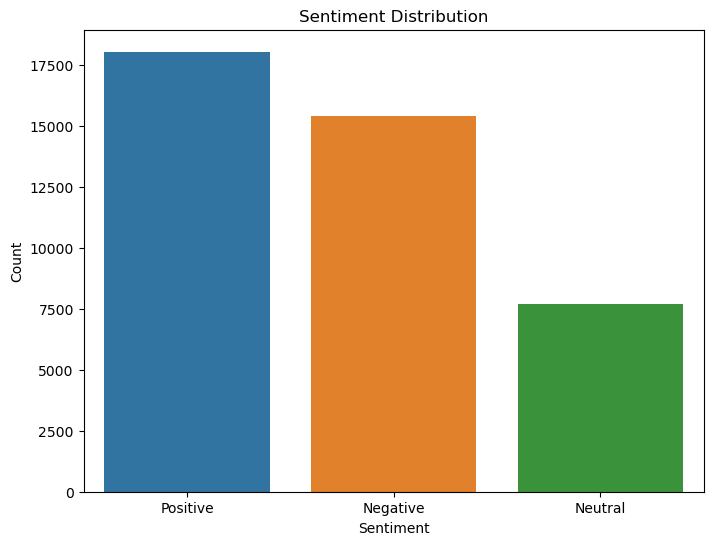

In [31]:
plt.figure(figsize=(8, 6))
sns.countplot(data=train, x='Sentiment')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Word Cloud

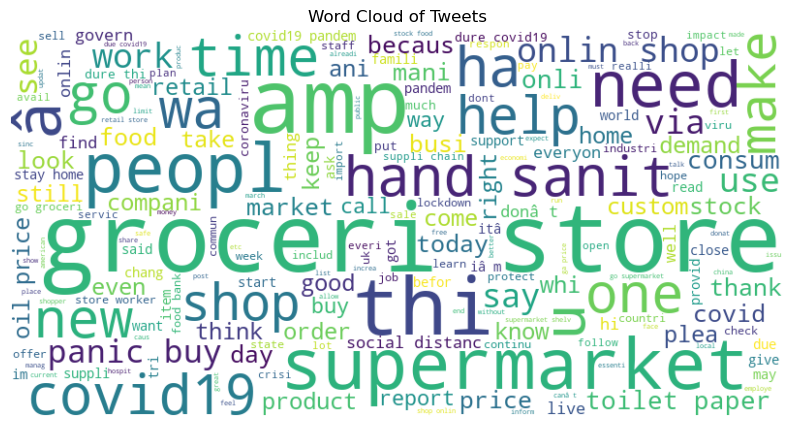

In [32]:
all_tweets_text = " ".join(tweet for tweet in train['OriginalTweet'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tweets_text)


plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets')
plt.show()

In [86]:
x = train['OriginalTweet']
y = train['Sentiment']

In [87]:
x.shape

(41157,)

# Vectorization

## TF-IDF 

In [35]:
corpus = []
for i in range(x.shape[0]):
    corpus.append(x.iloc[i])

In [36]:
vectorizer1 = TfidfVectorizer(max_features=1000)
X1 = vectorizer1.fit_transform(x)
feature_names1 = vectorizer1.get_feature_names_out()
denselist1 = X1.todense().tolist()
train = pd.DataFrame(denselist1, columns=feature_names1)

In [37]:
X_temp, X_test, y_temp, y_test = train_test_split(train, y, test_size=0.2, random_state=0)


In [38]:
accuracy = {'TF-IDF':[]}


# Models

## Logistic Regression

In [39]:
regressor_LR_tf = LogisticRegression(C=1.0,penalty='l2',solver='newton-cg')
regressor_LR_tf.fit(X_temp, y_temp)
y_predict_LR_tf = regressor_LR_tf.predict(X_test)
a=(regressor_LR_tf.score(X_test, y_test))
accuracy['TF-IDF'].append(a)

print(metrics.confusion_matrix(y_test, y_predict_LR_tf))
print(metrics.classification_report(y_test, y_predict_LR_tf))
print(metrics.accuracy_score(y_test, y_predict_LR_tf))

[[2258  253  476]
 [ 257  993  302]
 [ 457  261 2975]]
              precision    recall  f1-score   support

    Negative       0.76      0.76      0.76      2987
     Neutral       0.66      0.64      0.65      1552
    Positive       0.79      0.81      0.80      3693

    accuracy                           0.76      8232
   macro avg       0.74      0.73      0.74      8232
weighted avg       0.76      0.76      0.76      8232

0.7563168124392614


## Decision Tree

In [40]:
model_DT_tf = DecisionTreeClassifier(criterion = 'gini', max_depth=2) 
model_DT_tf.fit(X_temp, y_temp)
y_predict_DT_tf = model_DT_tf.predict(X_test)
a=(model_DT_tf.score(X_test,y_test))
accuracy['TF-IDF'].append(a)

print(metrics.confusion_matrix(y_test, y_predict_DT_tf))
print(metrics.classification_report(y_test, y_predict_DT_tf))
print(metrics.accuracy_score(y_test, y_predict_DT_tf))

[[ 353    0 2634]
 [  12    0 1540]
 [  67    0 3626]]
              precision    recall  f1-score   support

    Negative       0.82      0.12      0.21      2987
     Neutral       0.00      0.00      0.00      1552
    Positive       0.46      0.98      0.63      3693

    accuracy                           0.48      8232
   macro avg       0.43      0.37      0.28      8232
weighted avg       0.51      0.48      0.36      8232

0.483357628765792


## Gradient Boosting 

In [41]:
model_GB_tf = GradientBoostingClassifier(learning_rate= 0.1, max_depth=3, n_estimators= 100,subsample=1.0) 
model_GB_tf.fit(X_temp, y_temp)
y_predict_GB_tf = model_GB_tf.predict(X_test)
a=(model_GB_tf.score(X_test,y_test))
accuracy['TF-IDF'].append(a)
print(metrics.confusion_matrix(y_test, y_predict_GB_tf))
print(metrics.classification_report(y_test, y_predict_GB_tf))
print(metrics.accuracy_score(y_test, y_predict_GB_tf))

[[1930  135  922]
 [ 249  419  884]
 [ 468  143 3082]]
              precision    recall  f1-score   support

    Negative       0.73      0.65      0.69      2987
     Neutral       0.60      0.27      0.37      1552
    Positive       0.63      0.83      0.72      3693

    accuracy                           0.66      8232
   macro avg       0.65      0.58      0.59      8232
weighted avg       0.66      0.66      0.64      8232

0.6597424684159378


## Random Forest

In [42]:
model_RF_tf = RandomForestClassifier(n_estimators= 100, max_features = 'log2')
model_RF_tf.fit(X_temp, y_temp)
y_predict_RF_tf = model_RF_tf.predict(X_test)
a=(model_RF_tf.score(X_test,y_test))
accuracy['TF-IDF'].append(a)

print(metrics.confusion_matrix(y_test, y_predict_RF_tf))
print(metrics.classification_report(y_test, y_predict_RF_tf))
print(metrics.accuracy_score(y_test, y_predict_RF_tf))

[[2179  197  611]
 [ 288  912  352]
 [ 472  224 2997]]
              precision    recall  f1-score   support

    Negative       0.74      0.73      0.74      2987
     Neutral       0.68      0.59      0.63      1552
    Positive       0.76      0.81      0.78      3693

    accuracy                           0.74      8232
   macro avg       0.73      0.71      0.72      8232
weighted avg       0.74      0.74      0.74      8232

0.7395529640427599


## K Nearest Neighbour

In [43]:
model_KN_tf = KNeighborsClassifier(metric= 'manhattan', n_neighbors= 5, weights= 'distance') 
model_KN_tf.fit(X_temp, y_temp)
y_predict_KN_tf = model_KN_tf.predict(X_test)
a=(model_KN_tf.score(X_test,y_test))
accuracy['TF-IDF'].append(a)

print(metrics.confusion_matrix(y_test, y_predict_KN_tf))
print(metrics.classification_report(y_test, y_predict_KN_tf))
print(metrics.accuracy_score(y_test, y_predict_KN_tf))

[[ 367 2558   62]
 [  35 1470   47]
 [  47 3182  464]]
              precision    recall  f1-score   support

    Negative       0.82      0.12      0.21      2987
     Neutral       0.20      0.95      0.34      1552
    Positive       0.81      0.13      0.22      3693

    accuracy                           0.28      8232
   macro avg       0.61      0.40      0.26      8232
weighted avg       0.70      0.28      0.24      8232

0.2795189504373178


# Evaluation

In [44]:
model = ['LR','DT','GB','RF','KN']
data = {'model': model,'accuracy': accuracy['TF-IDF']}
compare_models = pd.DataFrame(data)
compare_models

,model,accuracy
0,LR,0.756317
1,DT,0.483358
2,GB,0.659742
3,RF,0.739553
4,KN,0.279519


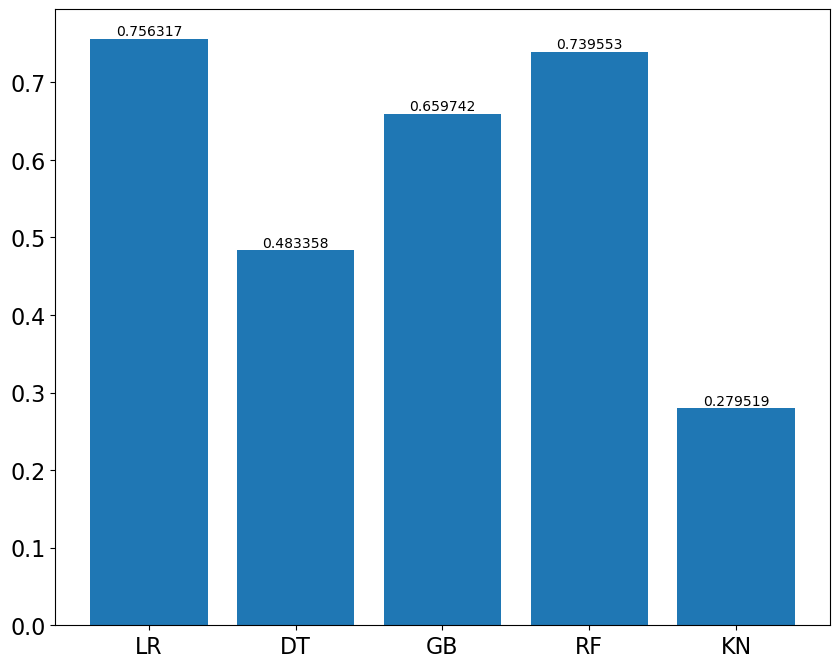

In [45]:
x, y = compare_models['model'],compare_models['accuracy']
ind = np.arange(len(y))
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(ind, y)
ax.set_xticks(ind)
ax.set_xticklabels(x)
ax.bar_label(ax.containers[0])
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.show()
#fig.savefig('Comparision of Models, TFIDF.pdf', format='pdf', bbox_inches = "tight")

## BoW

In [88]:
train = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv", encoding='latin-1')
test = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv", encoding='latin-1')

In [89]:
train=train.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis = 1)


In [90]:
dff = train.drop(['Sentiment'], axis = 1)


In [91]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(train, y, test_size=0.2, random_state=0)


In [92]:
X_test.shape, X_temp.shape, len(y_test), len(y_temp)


((8232, 2), (32925, 2), 8232, 32925)

In [93]:
X_temp['label'] = y_temp


In [94]:
X_temp.head()

,OriginalTweet,Sentiment,label
39386,The defining moment of the COVID-19 Zombie apo...,Negative,Negative
6354,Online shopping surge swamps warehouses as con...,Neutral,Neutral
40787,Senate Ad hoc committee led by Sen. @SakajaJoh...,Negative,Negative
25363,Life under coronavirus means staying at home a...,Positive,Positive
22737,State regulatory agencies are issuing guidance...,Neutral,Neutral


In [97]:
Positive = X_temp[X_temp['label'] == 'Positive']
Negative = X_temp[X_temp['label'] == 'Negative']
Neutral = X_temp[X_temp['label'] == 'Neutral']

Positive.shape[0], Negative.shape[0], Neutral.shape[0]

(9127, 7931, 6187)

In [98]:
ds = pd.concat([Positive, Negative, Neutral], axis = 0)


In [99]:
ds


,OriginalTweet,Sentiment,label
25363,Life under coronavirus means staying at home a...,Positive,Positive
30688,Earn easily just by creating a dummy purchase ...,Positive,Positive
37735,This graph shows how many people may die from ...,Positive,Positive
26884,.@RIFoodBank receives $100K from @MetLife Foun...,Positive,Positive
16102,Lysol Laundry Sanitizer Disinfectant Additive ...,Positive,Positive
...,...,...,...
16321,SUPERMARKET VISITATION/INSPECTION\r\r\nOn Marc...,Neutral,Neutral
37619,80 of states have closed dining areas There is...,Neutral,Neutral
2163,I just got home from 4 hours of stocking groce...,Neutral,Neutral
38984,Tips and #tricks for #grocery #shopping #onlin...,Neutral,Neutral


In [100]:
testdf = X_test
testdf['label'] = y_test
testdf.shape

(8232, 3)

In [101]:
len(testdf[testdf['label']=='Positive']),len(testdf[testdf['label']=='Negative']),len(testdf[testdf['label']=='Neutral']),len(testdf[testdf['label']=='Extremely Negative']),len(testdf[testdf['label']=='Extremely Positive'])


(2295, 1986, 1526, 1094, 1331)

In [102]:
ds = pd.concat([ds, testdf], axis = 0)


In [105]:
ds[ds['label']=='Positive'].shape, ds[ds['label']=='Negative'].shape, ds[ds['label']=='Neutral'].shape


((11422, 3), (9917, 3), (7713, 3))

In [106]:
corpus = []
for i in range(ds.shape[0]):
    corpus.append(ds.iloc[i][0])

In [107]:
vectorizer_train = CountVectorizer(max_features=1000)
vocabulary_train = vectorizer_train.fit_transform(corpus)
bow = pd.DataFrame(vocabulary_train.toarray(), columns = vectorizer_train.get_feature_names_out())

In [108]:
bow['labelxyz'] = list(ds.label)

In [110]:
bow_positive = bow[bow.labelxyz == 'Positive']
bow_negative = bow[bow.labelxyz == 'Negative']
bow_neutral = bow[bow.labelxyz == 'Neutral']

X_train_positive = bow_positive.sample(frac=0.8, random_state=0)
X_test_positive = bow_positive.drop(X_train_positive.index)
X_train_negative = bow_negative.sample(frac=0.8, random_state=0)
X_test_negative = bow_negative.drop(X_train_negative.index)
X_train_neutral = bow_neutral.sample(frac=0.8, random_state=0)
X_test_neutral = bow_neutral.drop(X_train_neutral.index)


X_train_df = pd.concat([X_train_positive, X_train_negative, X_train_neutral], axis = 0)
bow_train = X_train_df.drop(['labelxyz'], axis = 1)
y_train = list(X_train_df.labelxyz)
X_test_df = pd.concat([X_test_positive, X_test_negative, X_test_neutral], axis = 0)
bow_test = X_test_df.drop(['labelxyz'], axis = 1)
y_test = list(X_test_df.labelxyz)

In [111]:
model = ['LR','RF','DT','KN','GB']
accuracy = {'BOW':[]}

# Models

## Logistic Regression

In [112]:
regressor_LR_bow = LogisticRegression(C= 1.0, penalty='l2', solver= 'liblinear')
regressor_LR_bow.fit(bow_train,y_train)
y_predict_LR_bow = regressor_LR_bow.predict(bow_test)
a=(regressor_LR_bow.score(bow_test,y_test))
accuracy['BOW'].append(a)
print(metrics.confusion_matrix(y_test, y_predict_LR_bow))
print(metrics.classification_report(y_test, y_predict_LR_bow))
print(metrics.accuracy_score(y_test, y_predict_LR_bow))

[[1175  341  467]
 [ 223 1119  201]
 [ 381  386 1517]]
              precision    recall  f1-score   support

    Negative       0.66      0.59      0.62      1983
     Neutral       0.61      0.73      0.66      1543
    Positive       0.69      0.66      0.68      2284

    accuracy                           0.66      5810
   macro avg       0.65      0.66      0.65      5810
weighted avg       0.66      0.66      0.66      5810

0.6559380378657487


## Random Forest

In [113]:
model_RF_bow = RandomForestClassifier(max_features='sqrt', n_estimators= 1000)
model_RF_bow.fit(bow_train,y_train)
y_predict_RF_bow = model_RF_bow.predict(bow_test)
a=(model_RF_bow.score(bow_test,y_test))
accuracy['BOW'].append(a)
print(metrics.confusion_matrix(y_test, y_predict_RF_bow))
print(metrics.classification_report(y_test, y_predict_RF_bow))
print(metrics.accuracy_score(y_test, y_predict_RF_bow))

[[1056  254  673]
 [ 191  932  420]
 [ 391  296 1597]]
              precision    recall  f1-score   support

    Negative       0.64      0.53      0.58      1983
     Neutral       0.63      0.60      0.62      1543
    Positive       0.59      0.70      0.64      2284

    accuracy                           0.62      5810
   macro avg       0.62      0.61      0.61      5810
weighted avg       0.62      0.62      0.62      5810

0.617039586919105


## Decision Tree

In [114]:
model_DT_bow = DecisionTreeClassifier(criterion= 'gini', max_depth= 2) 
model_DT_bow.fit(bow_train,y_train)
y_predict_DT_bow = model_DT_bow.predict(bow_test)
a=(model_DT_bow.score(bow_test,y_test))
accuracy['BOW'].append(a)
print(metrics.confusion_matrix(y_test, y_predict_DT_bow))
print(metrics.classification_report(y_test, y_predict_DT_bow))
print(metrics.accuracy_score(y_test, y_predict_DT_bow))

[[ 168    0 1815]
 [  19    0 1524]
 [  57    0 2227]]
              precision    recall  f1-score   support

    Negative       0.69      0.08      0.15      1983
     Neutral       0.00      0.00      0.00      1543
    Positive       0.40      0.98      0.57      2284

    accuracy                           0.41      5810
   macro avg       0.36      0.35      0.24      5810
weighted avg       0.39      0.41      0.27      5810

0.41222030981067126


## K Neighbours

In [115]:
model_KN_bow = KNeighborsClassifier(metric= 'euclidean', n_neighbors= 19, weights= 'distance') 
model_KN_bow.fit(bow_train,y_train)
y_predict_KN_bow = model_KN_bow.predict(bow_test)
a=(model_KN_bow.score(bow_test,y_test))
accuracy['BOW'].append(a)
print(metrics.confusion_matrix(y_test, y_predict_KN_bow))
print(metrics.classification_report(y_test, y_predict_KN_bow))
print(metrics.accuracy_score(y_test, y_predict_KN_bow))

[[ 371 1384  228]
 [  79 1386   78]
 [ 241 1604  439]]
              precision    recall  f1-score   support

    Negative       0.54      0.19      0.28      1983
     Neutral       0.32      0.90      0.47      1543
    Positive       0.59      0.19      0.29      2284

    accuracy                           0.38      5810
   macro avg       0.48      0.43      0.35      5810
weighted avg       0.50      0.38      0.33      5810

0.3779690189328744


## Gradient Boosting

In [116]:
model_GB_bow = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, n_estimators= 100, subsample= 1.0)
model_GB_bow.fit(bow_train,y_train)
y_predict_GB_bow = model_GB_bow.predict(bow_test)
a=(model_GB_bow.score(bow_test,y_test))
accuracy['BOW'].append(a)
print(metrics.confusion_matrix(y_test, y_predict_GB_bow))
print(metrics.classification_report(y_test, y_predict_GB_bow))
print(metrics.accuracy_score(y_test, y_predict_GB_bow))

[[1034  336  613]
 [ 139  969  435]
 [ 364  392 1528]]
              precision    recall  f1-score   support

    Negative       0.67      0.52      0.59      1983
     Neutral       0.57      0.63      0.60      1543
    Positive       0.59      0.67      0.63      2284

    accuracy                           0.61      5810
   macro avg       0.61      0.61      0.60      5810
weighted avg       0.61      0.61      0.61      5810

0.6077452667814114


## Evaluation

In [117]:
data_bow = {'model':model,'accuracy':accuracy['BOW']}
compare_models_bow = pd.DataFrame(data_bow)
compare_models_bow

,model,accuracy
0,LR,0.655938
1,RF,0.617040
2,DT,0.412220
3,KN,0.377969
4,GB,0.607745


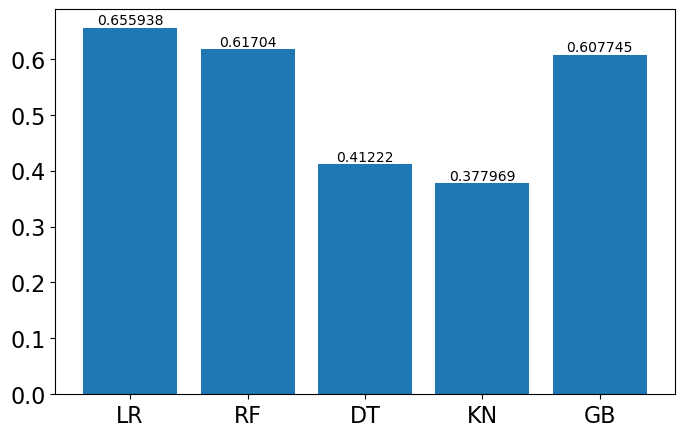

In [118]:
x, y = compare_models_bow['model'],compare_models_bow['accuracy']
ind = np.arange(len(y))
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(ind, y)
ax.set_xticks(ind)
ax.set_xticklabels(x)
ax.bar_label(ax.containers[0])
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.show()
fig.savefig('Comparision of Models, BoW.pdf', format='pdf')

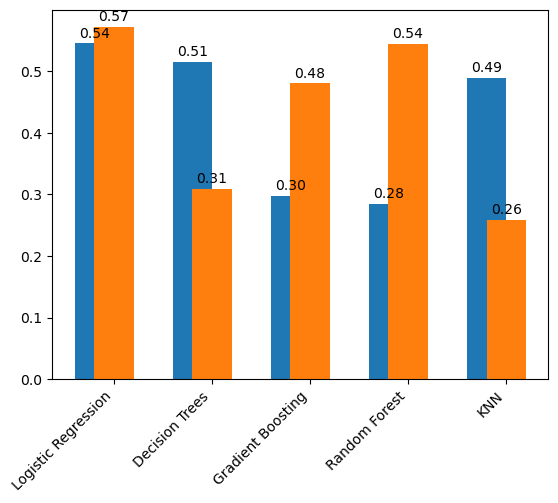

In [122]:
import matplotlib.pyplot as plt
import numpy as np

model = ['Logistic Regression', 'Decision Trees', 'Gradient Boosting', 'Random Forest', 'KNN']
position1 = np.arange(len(model))
position2 = [x + 0.2 for x in position1]  # Shifted by 0.2 for side-by-side placement

# Create the figure and axes
fig, ax = plt.subplots()
accuracy1 = [0.571186, 0.309281, 0.479956, 0.544461, 0.258017]
accuracy2 = [0.544891, 0.514397, 0.297291, 0.284170, 0.488883]

# Plot the bars
ax.bar(position1, accuracy2, width=0.4, label='BOW')
ax.bar(position2, accuracy1, width=0.4, label='TF-IDF')

# Set the x-axis tick positions and labels
ax.set_xticks(position1 + 0.2)  # Centering the ticks
ax.set_xticklabels(model, rotation=45, ha="right")  # Rotating labels for better readability

# Add data labels to the bars
for p1, p2 in zip(position1, position2):
    ax.text(p1, accuracy2[p1] + 0.01, f"{accuracy2[p1]:.2f}", ha="center")
    ax.text(p2, accuracy1[int(p2)] + 0.01, f"{accuracy1[int(p2)]:.2f}", ha="center")  # Convert p
